<a href="https://colab.research.google.com/github/Maheenms/GoogleCoLab/blob/main/NN_TuneUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import our dependencies
import pandas as pd
import matplotlib as plt
import sklearn as skl
import tensorflow as tf
from sklearn.datasets import make_circles

# Creating dummy nonlinear data
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, random_state=42)

# Transforming y_circles to a vertical vector
y_circles = y_circles.reshape(-1, 1)

# Use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_circles, y_circles, random_state=42)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

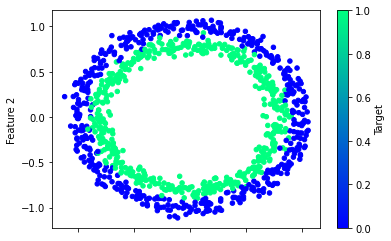

In [2]:
# Creating a DataFrame to plot the nonlinear dummy data

# Plot the nonlinear dummy data

df_circle = pd.DataFrame(X_circles, columns=["Feature 1", "Feature 2"])
df_circle["Target"] = y_circles
# Plot the nonlinear dummy data
df_circle.plot.scatter(x="Feature 1",y="Feature 2", c="Target",colormap="winter")


In [5]:
# Create a method that creates a new Sequential model with hyperparameter options

    # Allow kerastuner to decide which activation function to use in hidden layers
    
    # Allow kerastuner to decide number of neurons in first layer

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers

    # Compile the model

# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()
    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=2))
    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
        nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return nn_model



In [7]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 51.4 MB/s 


In [9]:
# Import the kerastuner library
import keras_tuner as kt

# Create a `Hyperband()` tuner instance

tuner = kt.Hyperband(
    create_model, 
    objective = 'val_accuracy',
    max_epochs = 30,
    hyperband_iterations = 3
)


In [10]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled, y_train, epochs = 30, validation_data =(X_test_scaled, y_test))

Trial 270 Complete [00h 00m 04s]
val_accuracy: 0.515999972820282

Best val_accuracy So Far: 0.6000000238418579
Total elapsed time: 00h 10m 06s


In [11]:
# Get top 3 model hyperparameters and print the values
# use get_best_hyperparamters() to get the best combo of hyperparameters
# (3) gets the best first 3 best combos
bestModels = tuner.get_best_hyperparameters(3)
for best in bestModels:
  print(best.values) # prints the dictionary of parameters

{'activation': 'tanh', 'first_units': 7, 'num_layers': 1, 'units_0': 7, 'units_1': 3, 'units_2': 5, 'units_3': 3, 'units_4': 5, 'units_5': 9, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0246'}
{'activation': 'relu', 'first_units': 5, 'num_layers': 1, 'units_0': 3, 'units_1': 9, 'units_2': 1, 'units_3': 7, 'units_4': 5, 'units_5': 5, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0168'}
{'activation': 'tanh', 'first_units': 7, 'num_layers': 1, 'units_0': 7, 'units_1': 3, 'units_2': 5, 'units_3': 3, 'units_4': 5, 'units_5': 9, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0247'}


In [12]:
# Evaluate the top 3 models against the test dataset
# use get_best_models to get the best models
bestCombos = tuner.get_best_models(3)
for best in bestCombos:
  model_loss, model_accuracy = best.evaluate(X_test_scaled, y_test, verbose= 2)
  print(model_loss)
  print(model_accuracy)
  print('--------------------------')

8/8 - 0s - loss: 0.6923 - accuracy: 0.6000 - 228ms/epoch - 28ms/step
0.6922932267189026
0.6000000238418579
--------------------------
8/8 - 0s - loss: 0.6685 - accuracy: 0.5880 - 235ms/epoch - 29ms/step
0.6685208678245544
0.5879999995231628
--------------------------
8/8 - 0s - loss: 0.6891 - accuracy: 0.5880 - 220ms/epoch - 27ms/step
0.6891107559204102
0.5879999995231628
--------------------------


In [13]:
# Get second best model hyperparameters
secondBest = tuner.get_best_hyperparameters(2)[1]
# Grabs the top 2 best performing in array, then grabs the 2nd index [1]. Index [0] would be the 'best' value

In [14]:
# Compare the performance to the second-best model
secondBestModel = tuner.get_best_models(2)[1]
model_loss, model_accuracy = secondBestModel.evaluate(X_test_scaled, y_test, verbose= 2)
print(model_loss)
print(model_accuracy)

8/8 - 0s - loss: 0.6685 - accuracy: 0.5880 - 238ms/epoch - 30ms/step
0.6685208678245544
0.5879999995231628
